# Eulerian outputs (idealized simulation) : Compute the correlation function for a given time window size (T) using the outputs on the model grid

The correlation function is computed using time series at each grid point (4kmx4km grid). The times series are separated in segments of size T and the correlation is computed over each segments and all segments are then combined. We average the results over bins (squares).

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal

import crocosi.postp as pp
import phdequinox.croco_drifter as cdr

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=8)
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster


In [3]:
client

Client Scheduler: tcp://10.148.0.191:37791 Dashboard: http://10.148.0.191:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Load data

In [4]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [5]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.Run(root_path+run, prefix='', outputs=['surf','his'], verbose=False)
r['surf'] = r['surf'].rename({'time_instant': 'time'})


In [6]:
# Select the number of points (dij) and the temporal resolution (dti)
V = ['u', 'v']
dij = 1
dti = 1
ds = (r['surf'][V].isel({'x_rho': slice(0,None,dij), 'x_u': slice(0,None,dij),
                         'y_rho': slice(0,None,dij), 'y_v': slice(0,None,dij),
                         'time': slice(0,None,dti)})
     ).squeeze()
print('dataset size: %.0f GB' %(ds.nbytes/1e9))

dataset size: 107 GB


In [7]:
#Chunks
x,y,t = 'auto', 'auto' , 'auto'
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [8]:
# Functions to interpolate the velocity on the rho grid (instead of the u or v grid)
from collections import OrderedDict

def _get_spatial_dims(v):
    """ Return an ordered dict of spatial dimensions in the s/z, y, x order
    """
    dims = OrderedDict( (d, next((x for x in v.dims if x[0]==d), None))
                        for d in ['s','y','x'] )
    return dims
def x2rho(v, grid,boundary):
    """ Interpolate from any grid to rho grid
    """
    dims = _get_spatial_dims(v)
    vout = v.copy()
    if dims['x'] == 'x_u':
        vout = grid.interp(vout, 'xi',boundary=boundary)
    if dims['y'] == 'y_v':
        vout = grid.interp(vout, 'eta',boundary=boundary)
    return vout

In [9]:
#Load the mean field
eulerian_field = xr.open_dataset(root_path+run+'diagnostics/Eulerian_field_ZC.nc').persist()
mean_zon = eulerian_field.mean('x_rho')

In [10]:
# Interpolation over the rho grid
for V in ['u','v']:
    ds[V] = x2rho(ds[V],r.xgrid,'extrapolate')
 #   ds[V] = ds[V]-mean_zon[V+'_mean'] # If mean field substracted : 


In [11]:
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:       (time: 72000, x_rho: 258, x_u: 257, y_rho: 722, y_v: 721)
Coordinates:
  * time          (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
  * x_rho         (x_rho) float32 -2000.0 2000.0 6000.0 ... 1022000.0 1026000.0
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    x_v           (x_rho) float32 dask.array<chunksize=(258,), meta=np.ndarray>
    time_counter  (time) float64 1.5e+03 1.5e+03 1.5e+03 ... 2e+03 2e+03 2e+03
    f_rho         (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
    s_rho_slice0  float32 -0.01
    f             (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * y_v           (y_v) float32 0.0 4000.0 8000.0 ... 2876000.0 2880000.0
Data variables:
    u             (time, y_rho, x_rho) float32 dask.array<chunksize=(1800, 231, 1), meta=np.ndarray>
    v             (time, y_rho, x_rho) float32 dask.array<chunksize=(1800, 1, 43), meta=np.ndarray>
Attributes:
    name:         surf
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2020-Feb-03 10:28:55 GMT
    uuid:         979d973b-3250-4199-96c2-7dff8e4f5076

In [12]:
ds = ds.chunk({'time': t, 'x_rho': x, 'x_u': x, 'y_rho': y, 'y_v': y})

In [13]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'same'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'same','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    vv = vv[...,int(vv.shape[-1]/2):]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1, _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [14]:
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [15]:
T = 40 #time window size (size of th segments)
dt = float((ds.time[1]-ds.time[0]).values) # time step
binsize = 50 # binsize over which the correlation will be averaged
_u = ds.v.isel(x_rho=slice(0,2),y_rho=slice(0,2))
lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(T/dt),detrend=False) #initialization of the lags (used as input)

In [16]:
# Autocorrelation of v
Cvv = wrap_correlate(ds.v, ds.v,dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))#.persist()
Cvv_mean = Cvv.mean('x_rho').compute()

In [17]:
# Autocorrelation of u
Cuu = wrap_correlate(ds.u, ds.u,dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))
Cuu_mean = Cuu.mean('x_rho').compute()

In [18]:
# Crosscorrelation uv 
Cuv = wrap_correlate(ds.u, ds.v,dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))
Cuv_mean = Cuv.mean('x_rho').compute()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:732: PerformanceWarning: Increasing number of chunks by factor of 43
  meta=meta,


In [19]:
# Crosscorrelation vu
Cvu = wrap_correlate(ds.v, ds.u,dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))
Cvu_mean = Cvu.mean('x_rho').compute()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/xarray/core/computation.py:732: PerformanceWarning: Increasing number of chunks by factor of 43
  meta=meta,


In [20]:
y_bins = np.arange(0,2800*1e3,binsize*1e3) # defintion of the bins
Cvv.groupby_bins('y_rho',y_bins)

DataArrayGroupBy, grouped over 'y_rho_bins' 
55 groups with labels (0.0,, 50000.0], ..., (2700000.0,, 2750000.0].

In [21]:
# Binning
y_bins = np.arange(0,2800*1e3,binsize*1e3) # defintion of the bins

Ruu_mean = Cuu_mean.groupby_bins('y_rho',y_bins).mean().rename() # Averaging
Ruu_mean = Ruu_mean.assign_coords({'y_rho_bins':[yy.mid for yy in Ruu_mean.y_rho_bins.values]}).rename({'y_rho_bins':'y_bins'})

In [22]:
R = Ruu_mean.to_dataset(name='uu')

In [23]:
# Binning in y direction for all correlation functions : 
y_bins = np.arange(0,2800*1e3,binsize*1e3)
for V,var in zip(['vv','uv','vu'],[Cvv_mean,Cuv_mean,Cvu_mean]):#,Cvu_mean
    Mean = var.groupby_bins('y_rho',y_bins).mean()
    R[V] = Mean.assign_coords({'y_rho_bins':[yy.mid for yy in Mean.y_rho_bins.values]}).rename({'y_rho_bins':'y_bins'})

In [24]:
attrs = {'Window' : T, 'Overlap' : 0.5, 'Bins_size' : binsize, 'Fourier window' : 'hann', 'removed':'total'}
R.attrs = attrs

In [25]:
R

<xarray.Dataset>
Dimensions:       (lags: 2880, y_bins: 55)
Coordinates:
  * y_bins        (y_bins) float64 2.5e+04 7.5e+04 ... 2.675e+06 2.725e+06
    s_rho_slice0  float32 -0.01
  * lags          (lags) float64 0.0 0.006944 0.01389 ... 19.98 19.99 19.99
Data variables:
    uu            (y_bins, lags) float64 8.691e-05 8.657e-05 ... -4.468e-06
    vv            (y_bins, lags) float64 0.0002752 0.0002741 ... 7.011e-06
    uv            (y_bins, lags) float64 2.54e-05 3.827e-05 ... 7.904e-06
    vu            (y_bins, lags) float64 2.54e-05 1.234e-05 ... -1.094e-05
Attributes:
    Window:          40
    Overlap:         0.5
    Bins_size:       50
    Fourier window:  hann
    removed:         total

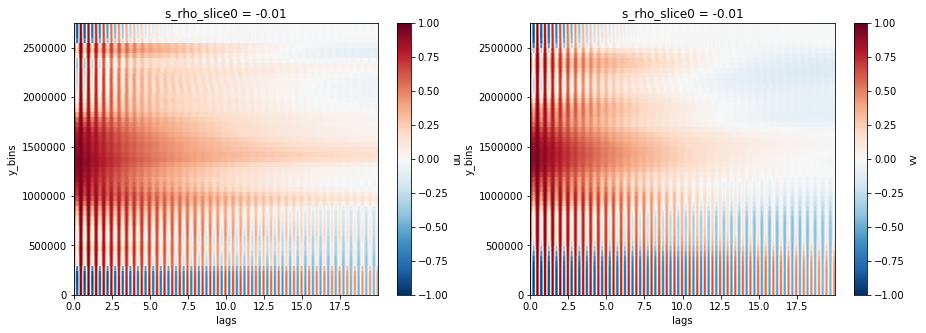

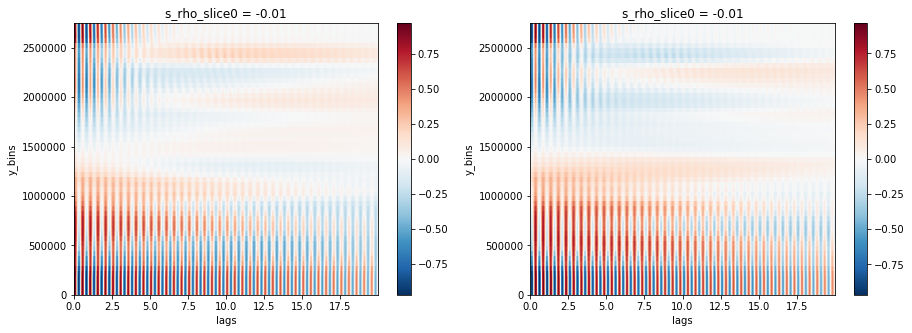

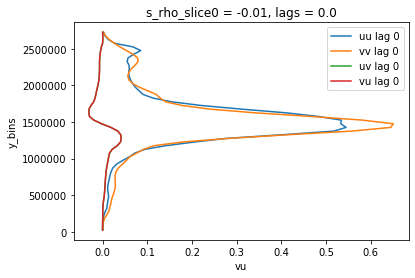

In [26]:
#Normalized autocorrelation (visualization 2D)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for V,ax in zip(['uu','vv'],axs):
    (R[V]/R[V].sel(lags=0.)).plot(ax=ax)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for V,ax in zip(['uv','vu'],axs):#,'vu'
    (R[V]/np.sqrt(R['uu'].sel(lags=0.)*R['vv'].sel(lags=0.))).plot(ax=ax)

plt.figure()
for V in ['uu','vv','uv','vu']:#,'vu'
    R[V].sel(lags=0).plot(y='y_bins',label='%s lag 0'%V)
plt.legend()

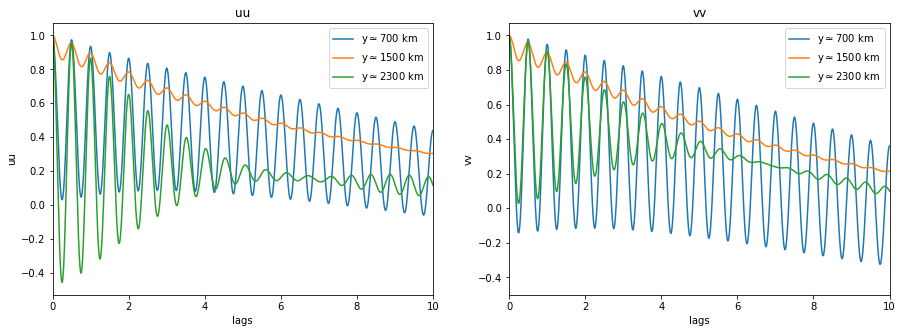

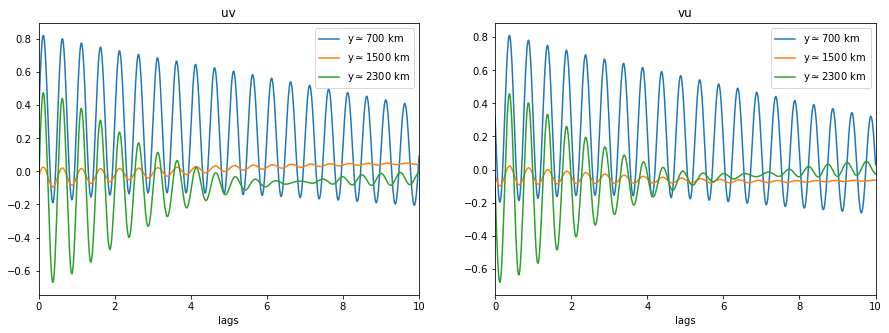

In [27]:
# Normalized functions for 3 y (South, jet and North)
Y = [700,1500,2300]
fig,axs=plt.subplots(1,2,figsize=(15,5))
for y in Y:
    for V,ax in zip(['uu','vv'],axs):
        (R[V]/R[V].sel(lags=0.)).sel(y_bins=y*1e3,method='nearest').plot(ax=ax,label=r'y$\simeq$%s km'%y)
        ax.legend();ax.set_title(V);ax.set_xlim(0,10)
fig,axs=plt.subplots(1,2,figsize=(15,5))
for y in Y:
    for V,ax in zip(['uv','vu'],axs):
        (R[V]/np.sqrt(R['uu'].sel(lags=0.)*R['vv'].sel(lags=0.))).sel(y_bins=y*1e3,method='nearest').plot(ax=ax,label=r'y$\simeq$%s km'%y
                                                                                                      )
        ax.legend();ax.set_title(V);ax.set_xlim(0,10)

#### Definition of attributes and storage of the results
The name of the nc files are name of the user_ouptuts used (drifters or eulerian)_corr_time window size&code\
The code used after the time window size is d if detrended data, avg1d or avg2d for average (1d or 2d) removed, total if nothing is removed. The removed part of signal are to be indicated in the attributes of the dataset ds.

In [28]:
# Storage
r.store_diagnostic('ZC_Eulerian_corr_40total', R, overwrite=True,file_format='netcdf')

data stored in /home/datawork-lops-osi/equinox/jetn/old/jet_cfg1_wp75_4km_1500a2000j_itide/diagnostics/ZC_Eulerian_corr_40total.nc


In [29]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
